#### **import important libraries**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from text_processor import TextProcessor

In [2]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


#### **load data**

In [3]:
path = 'F:\Sentiment-Analysis-App\dataset\IMDB Dataset.csv'
data = pd.read_csv(path)
data.head()

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Muhammad\AppData\Local\Temp\ipykernel_5004\3017338756.py:1: SyntaxWarning: invalid escape sequence '\S'
  path = 'F:\Sentiment-Analysis-App\dataset\IMDB Dataset.csv'
C:\Users\Muhammad\AppData\Local\Temp\ipykernel_5004\3017338756.py:1: SyntaxWarning: invalid escape sequence '\S'
  path = 'F:\Sentiment-Analysis-App\dataset\IMDB Dataset.csv'


NameError: name 'pd' is not defined

<Axes: xlabel='sentiment', ylabel='count'>

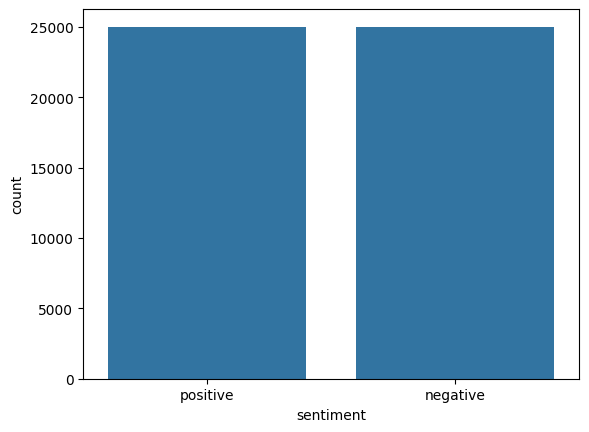

In [8]:
sns.barplot(data.sentiment.value_counts())

#### **preprocess data**

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [10]:
%%time
data['review'] = data['review'].apply(TextProcessor.preprocess)
data

f:\Sentiment-Analysis-App\text_processor.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


CPU times: total: 47.8 s
Wall time: 1min 5s


,review,sentiment
0,one reviewer mentioned watching 1 oz episode h...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,going disagree previous comment side maltin on...,negative


#### **split data**

In [11]:
X = data['review']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### **encode data**

In [12]:
y_train = y_train.map({'positive': 1, 'negative': 0})
y_test = y_test.map({'positive': 1, 'negative': 0})

#### **convert data to Tfidf**

In [13]:
# Vectorizing with TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=50000, 
    ngram_range=(1, 2), 
    max_df=0.7,min_df=3, 
    sublinear_tf=True
)
X_train_vec_tfidf = tfidf_vectorizer.fit_transform(X_train)  # Learn vocabulary and transform training data
X_test_vec_tfidf = tfidf_vectorizer.transform(X_test)        # Transform test data using the same vocabulary

#### **creating logistic regression model**

In [14]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

##### **train model**

In [15]:
# Count Vectorizer Logistic Regression
lg_model = LogisticRegression(max_iter=5000, solver='liblinear', C=1.0)
lg_model.fit(X_train_vec_tfidf, y_train) # Train on count vectorized data

LogisticRegression(max_iter=5000, solver='liblinear')

##### **evaluate model**

CountVectorizer Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      5000
           1       0.89      0.92      0.91      5000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



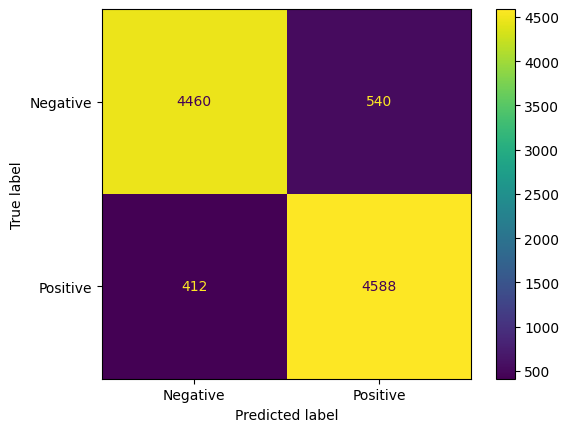

In [16]:
y_pred = lg_model.predict(X_test_vec_tfidf)                # Predict on test data
cm = confusion_matrix(y_test, y_pred)                      # Confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot()
print("CountVectorizer Classification Report:\n", classification_report(y_test, y_pred))

In [17]:
print("Final Optimized Model Accuracy:", accuracy_score(y_test, y_pred)*100)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Final Optimized Model Accuracy: 90.48

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      5000
           1       0.89      0.92      0.91      5000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



#### **there is an overfitting problem**

In [18]:
print(accuracy_score(y_train, lg_model.predict(X_train_vec_tfidf)))
print(accuracy_score(y_test, lg_model.predict(X_test_vec_tfidf)))

0.941325
0.9048


#### **use cross validation and hyperparameter tuning**

In [19]:
lg_cv_model = LogisticRegressionCV(
    Cs=15,
    cv=5,
    penalty='l2',
    scoring='accuracy',
    max_iter=10000,
    random_state=42,
    solver='lbfgs' #Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm
)
# count Vectorizer Logistic Regression
lg_cv_model.fit(X_train_vec_tfidf, y_train)     

LogisticRegressionCV(Cs=15, cv=5, max_iter=10000, random_state=42,
                     scoring='accuracy')

##### **evalute model**

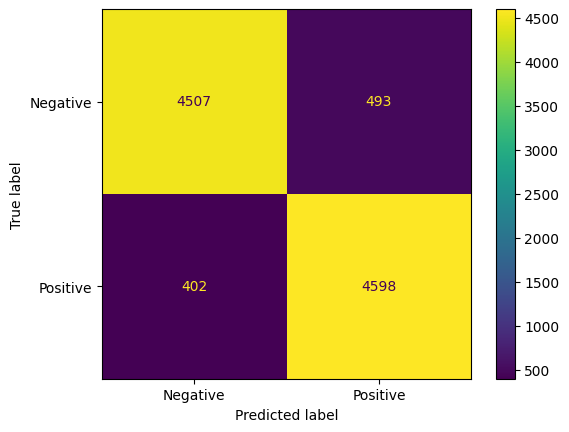

Count Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      5000
           1       0.90      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [20]:
# Train on count vectorized data
y_pred = lg_cv_model.predict(X_test_vec_tfidf)               # Predict on test data
cm = confusion_matrix(y_test, y_pred)                     # Confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot()
plt.show()
print("Count Classification Report:\n", classification_report(y_test, y_pred))

##### **compare train data and test data**

In [21]:
print(accuracy_score(y_train, lg_cv_model.predict(X_train_vec_tfidf)))
print(accuracy_score(y_test, lg_cv_model.predict(X_test_vec_tfidf)))

0.975725
0.9105


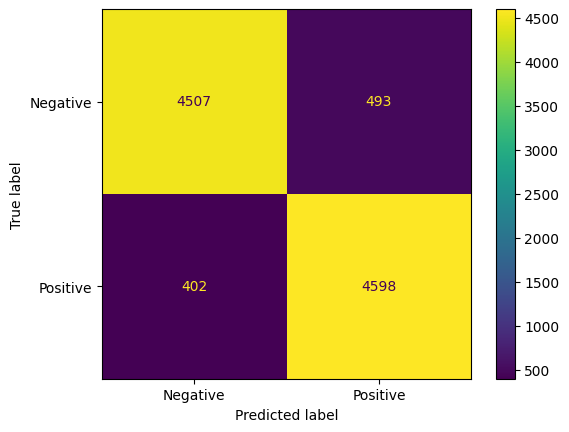

TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      5000
           1       0.90      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [22]:
# TF-IDF Vectorizer Logistic Regression
lg_cv_model.fit(X_train_vec_tfidf, y_train)                   # Train on TF-IDF vectorized data
y_pred = lg_cv_model.predict(X_test_vec_tfidf)               # Predict on test data
cm = confusion_matrix(y_test, y_pred)                     # Confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot()
plt.show()
print("TF-IDF Classification Report:\n", classification_report(y_test, y_pred))

##### **compare train data and test data**

In [23]:
print(accuracy_score(y_train, lg_cv_model.predict(X_train_vec_tfidf)))
print(accuracy_score(y_test, lg_cv_model.predict(X_test_vec_tfidf)))

0.975725
0.9105


In [24]:
print("Final Optimized Model Accuracy:", accuracy_score(y_test, y_pred)*100)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Final Optimized Model Accuracy: 91.05

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      5000
           1       0.90      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



### Export the model

In [30]:
from sklearn.pipeline import Pipeline
import joblib
from sklearn.metrics import accuracy_score

# Create a pipeline with the TF-IDF vectorizer and the trained Logistic Regression model
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),  # Step 1: TF-IDF vectorization
    ('model', lg_cv_model)        # Step 2: Logistic Regression model
])

# Save the pipeline to a file
pipeline_filename = 'pipeline.pkl'
joblib.dump(pipeline, pipeline_filename)
print(f"Pipeline exported to {pipeline_filename}")

# Load the pipeline and test it
loaded_pipeline = joblib.load(pipeline_filename)

# Pass raw text data (X_test) to the pipeline for prediction
test_prediction = loaded_pipeline.predict(X_test)

# Evaluate the accuracy of the loaded pipeline
print(f"Test Accuracy of Loaded Pipeline: {accuracy_score(y_test, test_prediction)*100}")


Pipeline exported to pipeline.pkl
Test Accuracy of Loaded Pipeline: 91.05
